In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [303]:
df = pd.read_csv('./output/data/merged_df.csv')

In [304]:
df.columns

Index(['file_path', 'label', 'duration', 'mfcc_1_mean', 'mfcc_2_mean',
       'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean',
       'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
       'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'mfcc_14_mean',
       'mfcc_15_mean', 'mfcc_16_mean', 'mfcc_17_mean', 'mfcc_18_mean',
       'mfcc_19_mean', 'mfcc_20_mean', 'mfcc_21_mean', 'mfcc_22_mean',
       'mfcc_23_mean', 'mfcc_24_mean', 'mfcc_25_mean', 'mfcc_26_mean',
       'mfcc_27_mean', 'mfcc_28_mean', 'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [305]:
# Drop the 'file_path' column
data = df.drop(columns=['file_path'])

# Convert 'label' column values from 'fake' and 'real' to 0 and 1
data['label'] = data['label'].apply(lambda x: 0 if x == 'fake' else 1)

# Display the updated dataframe
data.head()

,label,duration,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
0,1,6.840000,-304.341270,113.709097,-44.021291,28.256102,13.641230,-13.230529,-9.073119,-25.428404,...,-7.879508,-11.564848,-7.241586,-3.500644,-8.572959,-7.769196,-6.200805,-9.601032,-1.045484,1.696635
1,1,6.070000,-288.430056,156.781227,-42.138849,21.731352,9.175248,-37.561261,-14.877932,-15.617912,...,-10.782125,-11.156759,-9.278637,-7.561083,-6.570046,-6.295412,-5.074236,-3.588240,-3.976979,-4.318006
2,1,5.920000,-313.729559,133.650065,-45.776206,-0.649869,-4.962584,-27.823752,-4.273122,-20.606474,...,-7.809381,-3.840896,-4.639575,-5.083332,-2.645830,-3.523515,-4.064678,-1.823462,-1.784046,-3.711713
3,1,9.849958,-338.528304,110.269715,-26.445261,7.784086,12.008307,-15.176674,-9.363117,-12.151247,...,-6.991639,-4.952648,-4.918112,-5.376414,-5.329774,-4.305240,-3.679742,-3.917728,-2.481780,-1.619357
4,1,5.529958,-288.435487,117.139206,-53.460400,14.722782,-4.214957,-40.313201,-18.616485,-16.192421,...,-8.898185,-8.144262,-5.093298,0.412901,0.513141,1.108503,1.737505,-0.865436,0.617007,0.743553


In [306]:
data.shape

(28491, 32)

In [307]:
features = data.drop(columns=['label','duration'], axis=1).copy()
labels = data['label']

In [308]:
features.columns

Index(['mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [309]:
features.columns.shape[0]

30

In [310]:
features.describe()

,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
count,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,...,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000,28491.000000
mean,-294.359469,128.350110,-49.939734,15.695844,-8.824434,-29.239431,-17.556254,-26.498350,-21.781870,-17.318533,...,-7.305454,-7.305075,-5.444083,-4.355791,-4.104175,-2.991264,-1.916637,-1.077528,-0.862772,-0.321956
std,40.110791,16.737861,20.477045,16.431307,16.548927,8.218472,8.105849,10.900011,6.412058,6.232104,...,3.147947,3.109818,3.162339,3.340511,3.429335,3.796955,3.868063,3.907461,4.091424,4.239001
min,-427.511202,41.619881,-132.519799,-51.660638,-73.887088,-59.937041,-66.826030,-68.913723,-52.224983,-43.391347,...,-19.634654,-28.179092,-22.594905,-16.254429,-17.817578,-13.649520,-18.293898,-14.292117,-13.600392,-12.256773
25%,-325.550267,117.618470,-64.459261,4.238973,-21.303096,-34.501820,-22.597311,-35.113745,-25.754628,-21.289619,...,-9.389770,-9.090538,-7.337905,-6.455320,-6.185438,-5.254311,-4.380936,-3.548065,-3.339132,-3.135386
50%,-295.269233,128.650029,-51.033699,13.861626,-4.930721,-29.244040,-17.094298,-23.986145,-21.812266,-16.632084,...,-7.402455,-7.299450,-5.633367,-4.734413,-4.513160,-3.621158,-2.682717,-1.815018,-1.850596,-1.405937
75%,-262.311238,139.628672,-35.862019,25.983439,3.701130,-24.059418,-11.939252,-18.003519,-17.702517,-13.075360,...,-5.417171,-5.524412,-3.906976,-2.751645,-2.585890,-1.648368,-0.335136,0.505707,0.550261,1.532514
max,-124.937522,188.442505,28.522664,131.139593,40.257805,1.311399,14.682796,-0.963064,6.557127,18.941476,...,19.440140,13.960390,25.641637,26.610271,23.217386,27.676192,32.457459,27.320994,35.068053,31.041156


In [311]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2, l1_l2, l1
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense
from utils import create_sequences
import pickle

In [312]:
# 1. Create sequences
sequence_length = 10
overlap = 3
print(features.shape)
sequences, indices = create_sequences(features, sequence_length, overlap)
labels = labels[indices]

# 2. Pad sequences
padded_sequences = pad_sequences(
    sequences, maxlen=2, padding="pre", truncating="post"
)

# 1. First split the data
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, 
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 2. Fit scaler only on training data
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

# Fit on training, transform both
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)

# 3. Reshape back
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
# Save the train and validation data
np.save('./output/X_train.npy', X_train)
np.save('./output/X_val.npy', X_val)
np.save('./output/y_train.npy', y_train)
np.save('./output/y_val.npy', y_val)
with open('./output/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

(28491, 30)


In [313]:
padded_sequences[0].shape

(2, 30)

In [314]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, BatchNormalization

# 2. Create LSTM model
model = Sequential()
input_shape = (padded_sequences.shape[1], padded_sequences.shape[2])
model.add(Input(shape=input_shape))
model.add((LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add((LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add((LSTM(128, return_sequences=False)))
# Fully Connected layers
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Adjust units as needed
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


# 3. Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.5), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 2, 128)         │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 2, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,521 (1.69 MB)

 Trainable params: 443,521 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [315]:
# 4. Training with separate validation data
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks ,
)

with open('./output/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5298 - loss: 1.0043 - val_accuracy: 0.5971 - val_loss: 0.9859 - learning_rate: 1.0000e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6007 - loss: 0.9799 - val_accuracy: 0.6130 - val_loss: 0.9623 - learning_rate: 1.0000e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6228 - loss: 0.9564 - val_accuracy: 0.6351 - val_loss: 0.9389 - learning_rate: 1.0000e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6321 - loss: 0.9329 - val_accuracy: 0.6474 - val_loss: 0.9145 - learning_rate: 1.0000e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6581 - loss: 0.9063 - val_accuracy: 0.6572 - val_loss: 0.8854 - learning_rate: 1.0000e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6767 - loss: 0.8738 - val_accuracy: 0.6658 - val_loss: 0.8467 - learning_rate: 1.0000e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 

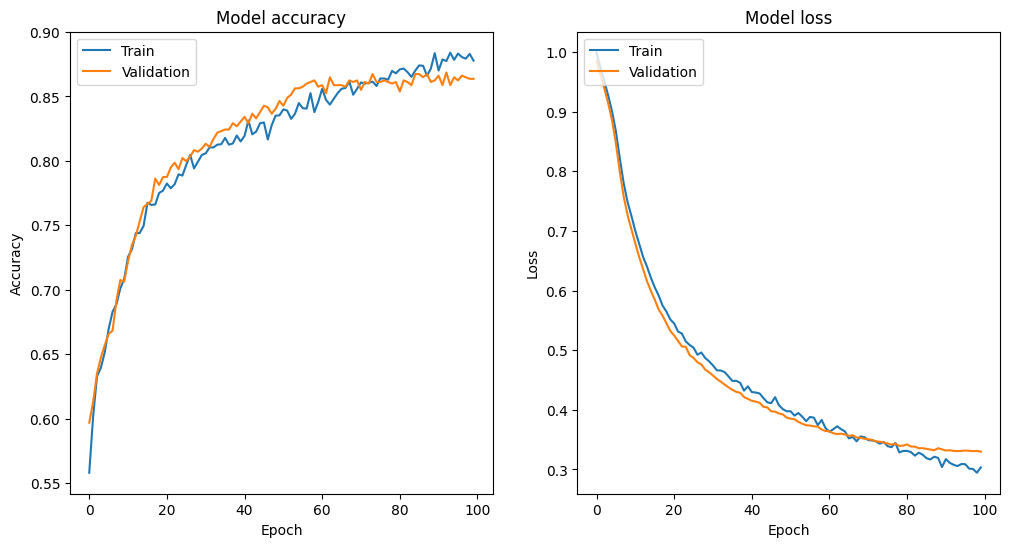

In [331]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [328]:
from scipy.ndimage import gaussian_filter1d

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

sacc = gaussian_filter1d(acc, sigma=2)
sval_acc = gaussian_filter1d(val_acc, sigma=2)

sloss = gaussian_filter1d(loss, sigma=2)
sval_loss = gaussian_filter1d(val_loss, sigma=2)


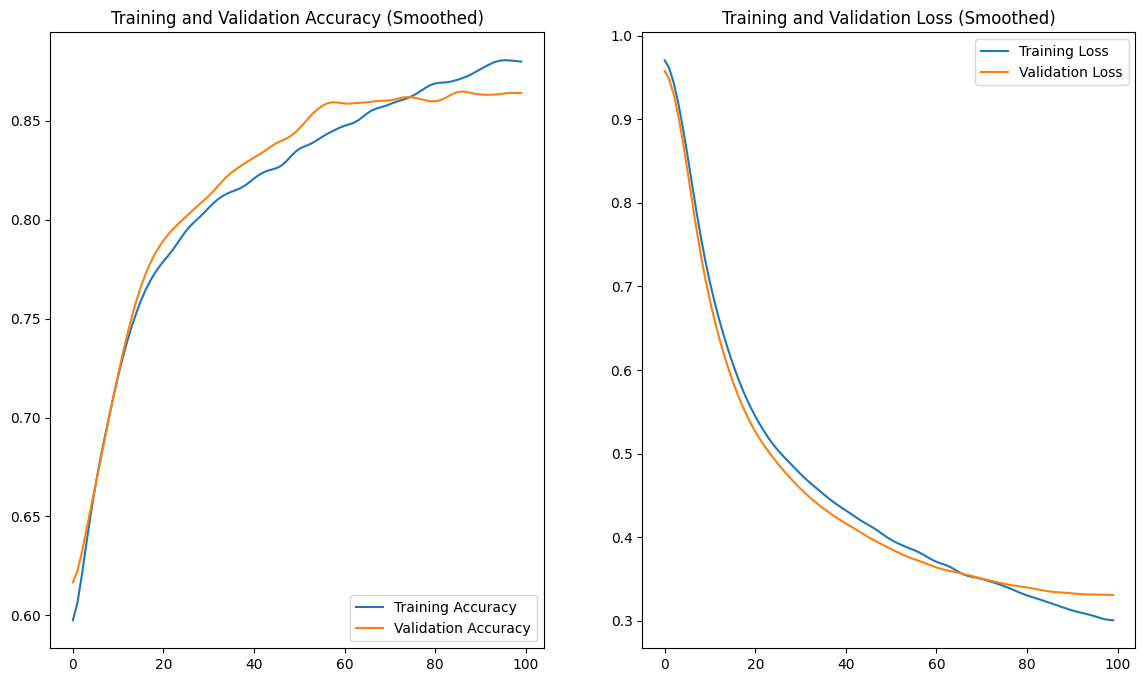

In [330]:
EPOCHS = len(acc)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), sacc, label='Training Accuracy')
plt.plot(range(EPOCHS), sval_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Smoothed)')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), sloss, label='Training Loss')
plt.plot(range(EPOCHS), sval_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Smoothed)')
plt.show()

# Evaluation

In [321]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       406
           1       0.86      0.87      0.86       408

    accuracy                           0.86       814
   macro avg       0.86      0.86      0.86       814
weighted avg       0.86      0.86      0.86       814



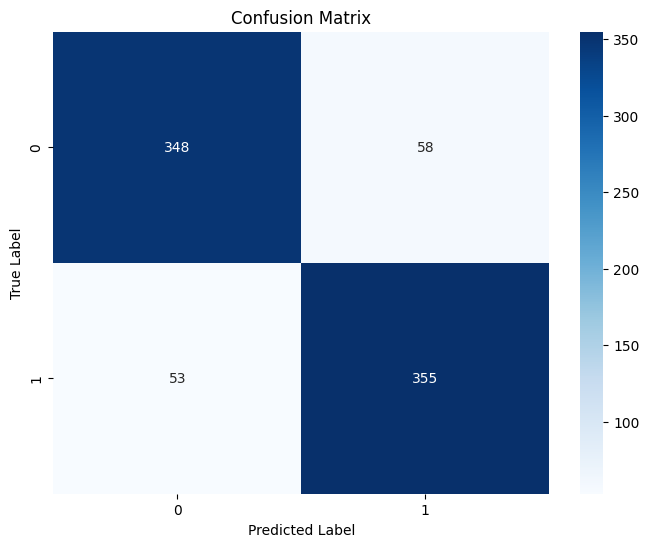

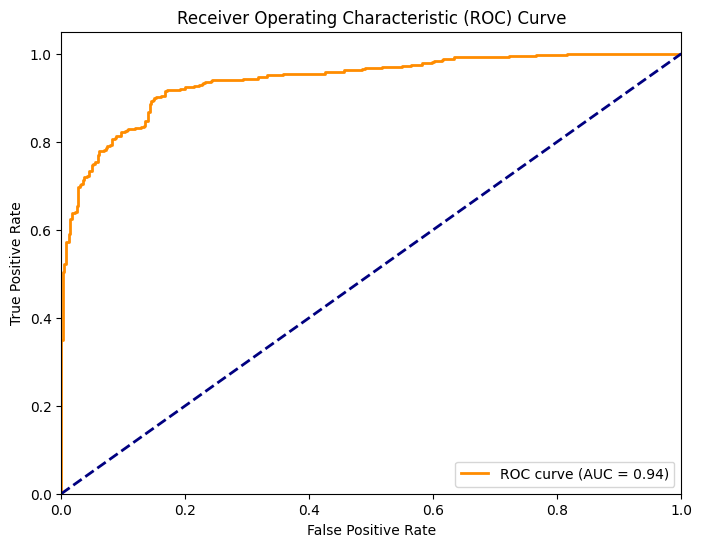


Detailed Metrics:
AUC-ROC Score: 0.9395
Accuracy: 0.8636
True Negatives: 348
False Positives: 58
False Negatives: 53
True Positives: 355


In [322]:
# 1. Load model and predict
model = keras.models.load_model("best_model.keras")
y_pred = model.predict(X_val_scaled)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# 2. Print classification metrics
print("\nClassification Report:")
print(classification_report(y_val, y_pred_binary))

# 3. Create confusion matrix
cm = confusion_matrix(y_val, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 5. Print additional metrics
print("\nDetailed Metrics:")
print(f"AUC-ROC Score: {roc_auc:.4f}")
print(f"Accuracy: {(y_pred_binary == y_val).mean():.4f}")
print(f"True Negatives: {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives: {cm[1][1]}")